#**KLASIFIKASI CITRA NYAMUK BERBASIS CNN MENGGUNAKAN EFFICIENTNETB2**

Kelompok ELDIVO
- Elisabet Simanjuntak (221402035)
- Yemima Fransiska Simanjuntak (221402041)
- Christy Eliana Simarmata (221402089)

#### Menghubungkan Colab dengan Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
import zipfile
import os

#### Mengakses Direktori Data Train dan Test

In [3]:
TRAIN_DIR = '/content/drive/MyDrive/ACD/DATASET/train'
TEST_DIR  = '/content/drive/MyDrive/ACD/DATASET/test'


## MENGIMPOR LIBRARY

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import itertools


#### Resizing dan Mengatur Batch Size

In [5]:
IMG_SIZE = (260, 260)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

## IMAGE PRE-PROCESSING

#### Membagi Data Train Menjadi 80% Training dan 20% Validation

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 1248 files belonging to 3 classes.
Using 999 files for training.
Found 1248 files belonging to 3 classes.
Using 249 files for validation.
Found 312 files belonging to 3 classes.
Classes: ['Aedes aegypti', 'Aedes albopictus', 'Culex quinquefasciatus']


#### Data Augmentation

Komposisi augmentasi yang digunakan adalah flip, rotasi, zoom, contrast.

In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3),
], name="data_augmentation")


In [8]:
def prepare(ds, training=False):
    def _map(x, y):
        x = tf.image.resize(x, IMG_SIZE)
        x = tf.cast(x, tf.float32)
        if training:
            x = data_augmentation(x, training=True)
        x = preprocess_input(x)
        return x, y

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    return ds.prefetch(AUTOTUNE)

train_ds_prep = prepare(train_ds, training=True)
val_ds_prep   = prepare(val_ds, training=False)
test_ds_prep  = prepare(test_ds, training=False )


## MEMBANGUN MODEL

#### Menginisiasi Transfer Learning EfficientNetB2

In [9]:
base_model = EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Membangun Arsitektur Klasifikasi

In [10]:
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

#### Compiling Model

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#### Menampilkan Rengkuman Model

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 9, 9, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         4,227 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,772,796 (29.65 MB)

 Trainable params: 4,227 (16.51 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

#### Menyimpan Model

In [13]:
best_path = "/content/drive/MyDrive/ACD/Model/best_model_efficienetb2.keras"

#### Callback Early Stopping dan Model Checkpoint

In [14]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=best_path,
        monitor="val_loss",
        save_best_only=True,
        mode="min"
    )
]

#### Head Training

In [15]:
history_fe = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs= 20,
    callbacks=callbacks
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.5095 - loss: 0.9637 - val_accuracy: 0.8353 - val_loss: 0.5243
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 167ms/step - accuracy: 0.7656 - loss: 0.5728 - val_accuracy: 0.8635 - val_loss: 0.4041
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.8293 - loss: 0.4416 - val_accuracy: 0.8514 - val_loss: 0.3568
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 152ms/step - accuracy: 0.8267 - loss: 0.4099 - val_accuracy: 0.8715 - val_loss: 0.3269
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 147ms/step - accuracy: 0.8464 - loss: 0.3767 - val_accuracy: 0.8755 - val_loss: 0.3006
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 142ms/step - accuracy: 0.8788 - loss: 0.3319 - val_accuracy: 0.8715 - val_loss: 0.2970
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 157ms/step - accuracy: 0.8850 - loss: 0.3199 - val_accuracy: 0.8876 - val_loss: 0.2751
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 163ms/step - accuracy: 0.8445 - loss: 0.3654 - val_accura

In [16]:

test_loss, test_acc = model.evaluate(test_ds_prep)
print("Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.9243 - loss: 0.2088
Test Accuracy: 0.9358974099159241


## CLASSIFICATION REPORT

In [17]:
y_true = np.concatenate([y.numpy() for _, y in test_ds_prep], axis=0)
y_pred_probs = model.predict(test_ds_prep)
y_pred = np.argmax(y_pred_probs, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 649ms/step


## CONFUSION MATRIX

Classification report:
                         precision    recall  f1-score   support

         Aedes aegypti       0.92      0.88      0.90       104
      Aedes albopictus       0.89      0.93      0.91       104
Culex quinquefasciatus       1.00      0.99      1.00       104

              accuracy                           0.94       312
             macro avg       0.94      0.94      0.94       312
          weighted avg       0.94      0.94      0.94       312

Confusion matrix:
 [[ 92  12   0]
 [  7  97   0]
 [  1   0 103]]


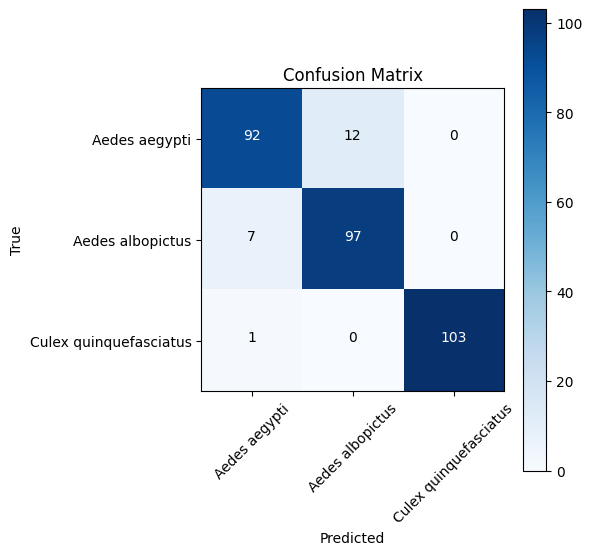

In [18]:
cm = confusion_matrix(y_true, y_pred)
print('Classification report:\n', classification_report(y_true, y_pred, target_names=class_names))
print('Confusion matrix:\n', cm)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names)

In [19]:
# Akurasi training per epoch
train_acc = history_fe.history['accuracy']

# Akurasi validasi per epoch
val_acc = history_fe.history['val_accuracy']

# Loss training per epoch
train_loss = history_fe.history['loss']

# Loss validasi per epoch
val_loss = history_fe.history['val_loss']

In [20]:
for i in range(len(train_acc)):
    print(f"Epoch {i+1}: "
          f"Train Acc = {train_acc[i]:.4f}, "
          f"Val Acc = {val_acc[i]:.4f}, "
          f"Train Loss = {train_loss[i]:.4f}, "
          f"Val Loss = {val_loss[i]:.4f}")

Epoch 1: Train Acc = 0.6577, Val Acc = 0.8353, Train Loss = 0.7966, Val Loss = 0.5243
Epoch 2: Train Acc = 0.7848, Val Acc = 0.8635, Train Loss = 0.5292, Val Loss = 0.4041
Epoch 3: Train Acc = 0.8348, Val Acc = 0.8514, Train Loss = 0.4326, Val Loss = 0.3568
Epoch 4: Train Acc = 0.8398, Val Acc = 0.8715, Train Loss = 0.3906, Val Loss = 0.3269
Epoch 5: Train Acc = 0.8448, Val Acc = 0.8755, Train Loss = 0.3814, Val Loss = 0.3006
Epoch 6: Train Acc = 0.8789, Val Acc = 0.8715, Train Loss = 0.3342, Val Loss = 0.2970
Epoch 7: Train Acc = 0.8819, Val Acc = 0.8876, Train Loss = 0.3297, Val Loss = 0.2751
Epoch 8: Train Acc = 0.8609, Val Acc = 0.8835, Train Loss = 0.3332, Val Loss = 0.2618
Epoch 9: Train Acc = 0.8929, Val Acc = 0.8956, Train Loss = 0.2984, Val Loss = 0.2525
Epoch 10: Train Acc = 0.9039, Val Acc = 0.9036, Train Loss = 0.2724, Val Loss = 0.2402
Epoch 11: Train Acc = 0.9059, Val Acc = 0.8996, Train Loss = 0.2737, Val Loss = 0.2420
Epoch 12: Train Acc = 0.9099, Val Acc = 0.8956, Trai

In [21]:
for i in range(len(train_acc)):
    gap = train_acc[i] - val_acc[i]
    print(f"Epoch {i+1}: "
          f"Train Acc = {train_acc[i]:.4f}, "
          f"Val Acc = {val_acc[i]:.4f}, "
          f"Gap = {gap:.4f}")

Epoch 1: Train Acc = 0.6577, Val Acc = 0.8353, Gap = -0.1777
Epoch 2: Train Acc = 0.7848, Val Acc = 0.8635, Gap = -0.0787
Epoch 3: Train Acc = 0.8348, Val Acc = 0.8514, Gap = -0.0166
Epoch 4: Train Acc = 0.8398, Val Acc = 0.8715, Gap = -0.0316
Epoch 5: Train Acc = 0.8448, Val Acc = 0.8755, Gap = -0.0307
Epoch 6: Train Acc = 0.8789, Val Acc = 0.8715, Gap = 0.0074
Epoch 7: Train Acc = 0.8819, Val Acc = 0.8876, Gap = -0.0057
Epoch 8: Train Acc = 0.8609, Val Acc = 0.8835, Gap = -0.0227
Epoch 9: Train Acc = 0.8929, Val Acc = 0.8956, Gap = -0.0027
Epoch 10: Train Acc = 0.9039, Val Acc = 0.9036, Gap = 0.0003
Epoch 11: Train Acc = 0.9059, Val Acc = 0.8996, Gap = 0.0063
Epoch 12: Train Acc = 0.9099, Val Acc = 0.8956, Gap = 0.0143
Epoch 13: Train Acc = 0.8949, Val Acc = 0.8996, Gap = -0.0047
Epoch 14: Train Acc = 0.8959, Val Acc = 0.8956, Gap = 0.0003
Epoch 15: Train Acc = 0.8909, Val Acc = 0.9116, Gap = -0.0208
Epoch 16: Train Acc = 0.8939, Val Acc = 0.9116, Gap = -0.0178
Epoch 17: Train Acc = 

## PLOT AKURASI DAN VALIDASI AKURASI TIAP EPOCH

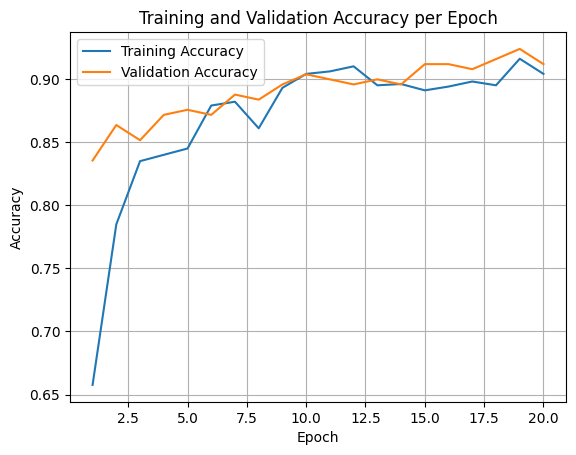

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)

plt.figure()
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.show()

## PLOT AKURASI DAN VALIDASI LOSS TIAP EPOCH

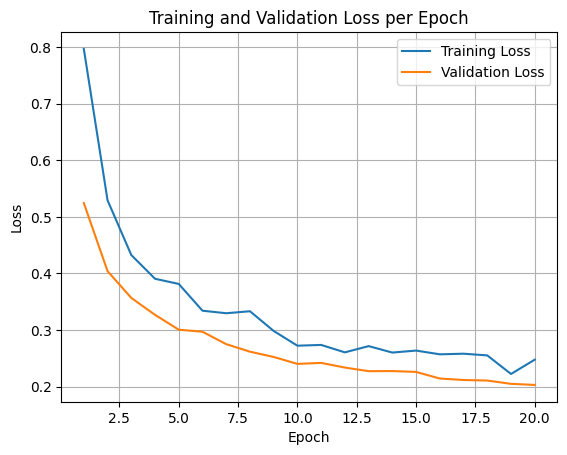

In [23]:
plt.figure()
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)

plt.show()

##  HASIL PREDIKSI

In [24]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import UnidentifiedImageError

TEST_DIR = '/content/drive/MyDrive/ACD/DATASET/test'
IMG_SIZE = (260, 260)

results = []
valid_ext = ('.jpg', '.jpeg', '.png')

for true_class in os.listdir(TEST_DIR):
    class_dir = os.path.join(TEST_DIR, true_class)

    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if not fname.lower().endswith(valid_ext):
            continue

        img_path = os.path.join(class_dir, fname)

        try:
            # Load image
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)

            # Preprocessing
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            # Prediction
            pred = model.predict(img_array, verbose=0)[0]
            pred_class = class_names[np.argmax(pred)]

            row = {
                "Filename": fname,
                "True Class": true_class,
                "Predicted Class": pred_class
            }

            for i, cname in enumerate(class_names):
                row[f"Prob_{cname} (%)"] = np.round(pred[i] * 100, 2)

            results.append(row)

        except UnidentifiedImageError:
            print(f"Bukan gambar: {img_path}")

# Convert ke DataFrame
df_results = pd.DataFrame(results)

print("Distribusi hasil prediksi:")
print(df_results["Predicted Class"].value_counts())
print(df_results.head())

# Simpan CSV
csv_path = "/content/drive/MyDrive/ACD/EB2_test_predictions.csv"
df_results.to_csv(csv_path, index=False)

print("Hasil disimpan ke:")
print(csv_path)


Distribusi hasil prediksi:
Predicted Class
Aedes albopictus          121
Culex quinquefasciatus    101
Aedes aegypti              90
Name: count, dtype: int64
          Filename              True Class         Predicted Class  \
0  landing_174.jpg  Culex quinquefasciatus  Culex quinquefasciatus   
1  landing_124.jpg  Culex quinquefasciatus           Aedes aegypti   
2  landing_126.jpg  Culex quinquefasciatus  Culex quinquefasciatus   
3  landing_116.jpg  Culex quinquefasciatus  Culex quinquefasciatus   
4  landing_100.jpg  Culex quinquefasciatus  Culex quinquefasciatus   

   Prob_Aedes aegypti (%)  Prob_Aedes albopictus (%)  \
0                1.810000                       0.19   
1               73.739998                       2.51   
2                2.840000                       0.10   
3                4.060000                       3.78   
4               45.830002                       0.33   

   Prob_Culex quinquefasciatus (%)  
0                        97.989998  
1        